In [1]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import cv2
import numpy as np
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import pandas as pd


In [2]:
#Utility Commands
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):

  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):

  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

# def to_gif(images, duration):
#   """Converts image sequence (4D numpy array) to gif."""
#   imageio.mimsave('./animation.gif', images, duration=duration)
#   return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [3]:
class PersonDetector:
    def __init__(self):
        model_path = "https://tfhub.dev/google/movenet/singlepose/thunder/4"
        self.movenet = self.load_model(model_path)
    
    def load_model(self,model_path):
        model = hub.load(model_path)
        movenet = model.signatures['serving_default']
        return movenet

    def get_model(self):
        return self.movenet
    
    def detect(self,input_image,inference_count=3):
        input_image = tf.cast(input_image, dtype=tf.int32)
        outputs = self.movenet(input_image)
        keypoints_with_scores = outputs['output_0'].numpy()
        return keypoints_with_scores

In [4]:
class ImageProcessor:
    def process_image(self,image_path):
        image = tf.io.read_file(image_path)
        image = tf.compat.v1.image.decode_jpeg(image)
        image = tf.expand_dims(image, axis=0)
        image = tf.cast(tf.image.resize_with_pad(image, 256, 256), dtype=tf.int32)
        return image
    
    def display_image(self,image):
        fig = plt.figure(figsize=(20, 15))
        plt.grid(False)
        plt.imshow(image[0])
        plt.show()
        
    def display_image_with_keypoints(self,image,keypoints):
        display_image = tf.cast(tf.image.resize_with_pad(
            image, 1280, 1280), dtype=tf.int32)
        output_overlay = draw_prediction_on_image(
            np.squeeze(display_image.numpy(), axis=0), keypoints)
        plt.figure(figsize=(5, 5))
        plt.imshow(output_overlay)
        _ = plt.axis('off')

In [5]:
detector = PersonDetector()

In [6]:
imageProcessor = ImageProcessor()

In [7]:
def load_image(detector:PersonDetector,imageProcessor:ImageProcessor,path:str):
    keypoint_data = []
    image_label = []
    angle_data = []
    for images in os.listdir(path):
        image = imageProcessor.process_image(os.path.join(path,images))
        keypoints = detector.detect(image)
        
        key = keypoints[0][0]
        keypoint_data.append(keypoints[0][0])
        image_label.append(images.split("_")[0])
        
        angle = calculate_angle(key)
        angle_data.append(angle)
    
        imageProcessor.display_image_with_keypoints(image,keypoints)
        
    angle_data = np.array(angle_data)
    
    result = pd.DataFrame()
    result["Data"] = keypoint_data
    result["Label"] = image_label
    result["Right Knee"] = angle_data.T[0]
    result["left Knee"] = angle_data.T[1]
    result["Right Hip"] = angle_data.T[2]
    result["Left Hip"] = angle_data.T[3]
    result["Right Elbow"] = angle_data.T[4]
    result["Left Elbow"] = angle_data.T[5]
    
    return result

def calculate_angle(key):
    
    right_wrist = key[10]
    left_wrist = key[9]
    
    right_elbow = key[8]
    left_elbow = key[7]
    
    right_shoulder = key[6]
    left_shoulder = key[5]
    
    right_hip = key[12]
    left_hip = key[11]
    
    right_knee = key[14]
    left_knee = key[13]
    
    right_ankle = key[16]
    left_ankle = key[15]
    
    angle_right_we = np.degrees(np.arctan2(right_wrist[1] - right_elbow[1], right_wrist[0] - right_elbow[0]))
    angle_right_es = np.degrees(np.arctan2(right_elbow[1] - right_shoulder[1], right_elbow[0] - right_shoulder[0]))
    angle_right_sh = np.degrees(np.arctan2(right_shoulder[1] - right_hip[1], right_shoulder[0] - right_hip[0]))
    angle_right_hk = np.degrees(np.arctan2(right_hip[1] - right_knee[1], right_hip[0] - right_knee[0]))
    angle_right_ka = np.degrees(np.arctan2(right_knee[1] - right_ankle[1], right_knee[0] - right_ankle[0]))
    
    angle_left_we = np.degrees(np.arctan2(left_wrist[1] - left_elbow[1], left_wrist[0] - left_elbow[0]))
    angle_left_es = np.degrees(np.arctan2(left_elbow[1] - left_shoulder[1], left_elbow[0] - left_shoulder[0]))
    angle_left_sh = np.degrees(np.arctan2(left_shoulder[1] - left_hip[1], left_shoulder[0] - left_hip[0]))
    angle_left_hk = np.degrees(np.arctan2(left_hip[1] - left_knee[1], left_hip[0] - left_knee[0]))
    angle_left_ka = np.degrees(np.arctan2(left_knee[1] - left_ankle[1], left_knee[0] - left_ankle[0]))
    
    angles = [angle_right_we,angle_right_es,angle_right_sh,angle_right_hk,angle_right_ka,angle_left_we,angle_left_es,angle_left_sh,angle_left_hk,angle_left_ka]
    angles = [angle if angle > 0 else angle + 360 for angle in angles]
    
    right_knee_angle = abs(angles[3] - angles[4])
    left_knee_angle = abs(angles[8] - angles[9])
    
    right_hip_angle = abs(angles[2] - angles[3])
    left_hip_angle = abs(angles[7] - angles[8])
    
    right_elbow_angle = abs(angles[0] - angles[1])
    left_elbow_angle = abs(angles[5] - angles[6])
    
    angles = [right_knee_angle,left_knee_angle,right_hip_angle,left_hip_angle,right_elbow_angle,left_elbow_angle]
    
    return angles

,Data,Label,Right Knee,left Knee,Right Hip,Left Hip,Right Elbow,Left Elbow
0,"[[0.12098136, 0.4792457, 0.70843047], [0.10183...",front,1.406418,1.164810,10.102982,9.255066,330.305946,333.976275
1,"[[0.21533872, 0.49773616, 0.7079618], [0.20129...",front,4.074570,10.865051,13.400375,13.307251,319.958893,319.380853
2,"[[0.14249271, 0.51836205, 0.534998], [0.128236...",front,2.298615,7.097336,0.412842,14.558701,3.329454,332.208441
3,"[[0.14085707, 0.43970647, 0.54761577], [0.1257...",side,4.550812,2.109604,2.505341,1.847549,13.457443,15.677880
4,"[[0.124385506, 0.4743575, 0.7242664], [0.10203...",side,3.442291,2.411148,2.407516,3.632172,21.635538,21.800730


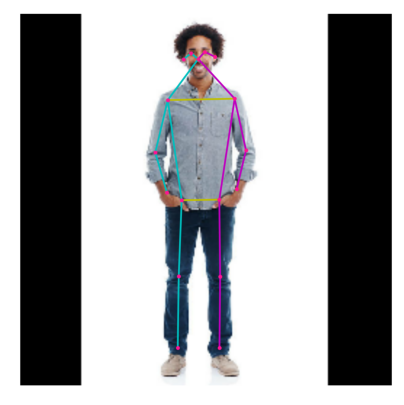

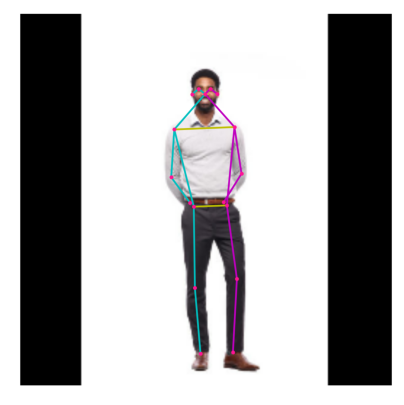

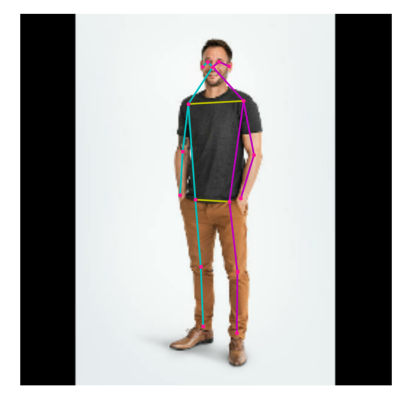

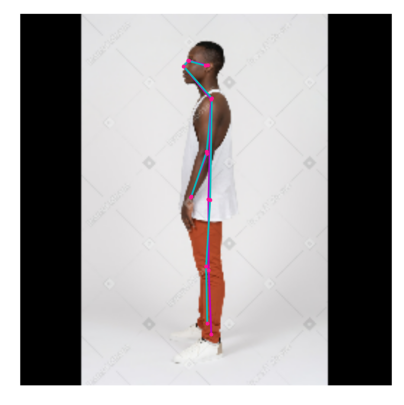

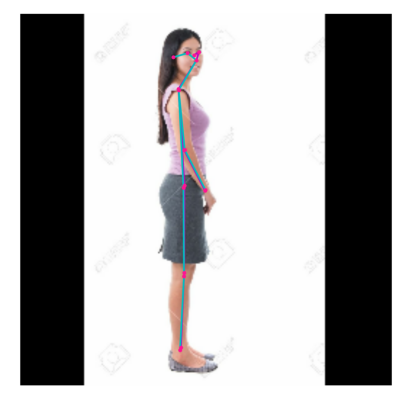

In [8]:
a = load_image(detector,imageProcessor,"../../Datasets/Trainer/raw/standing")
a

,Data,Label,Right Knee,left Knee,Right Hip,Left Hip,Right Elbow,Left Elbow
0,"[[0.2732513, 0.5244943, 0.6393904], [0.2691082...",jumping,14.748230,5.103729,13.859665,9.616196,74.235901,71.151611
1,"[[0.33596694, 0.68260616, 0.8504348], [0.31488...",situp,104.543549,119.700943,129.272919,125.591660,150.364822,108.643768
2,"[[0.44970602, 0.5787002, 0.54177356], [0.43362...",squat,105.021095,106.189583,109.537239,109.547722,110.265579,97.424210
3,"[[0.31545112, 0.4347699, 0.4797381], [0.298786...",squat,99.279976,101.149811,124.809700,127.468628,14.791527,11.786301


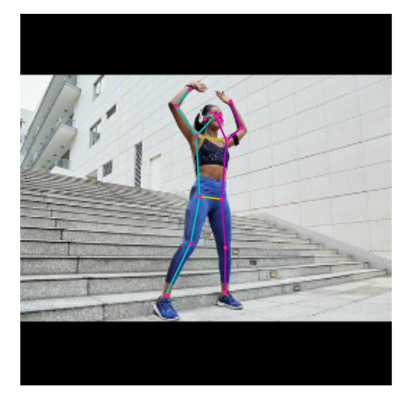

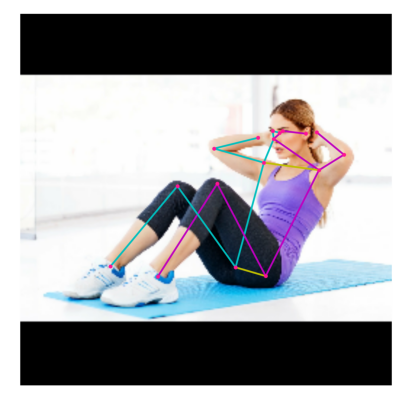

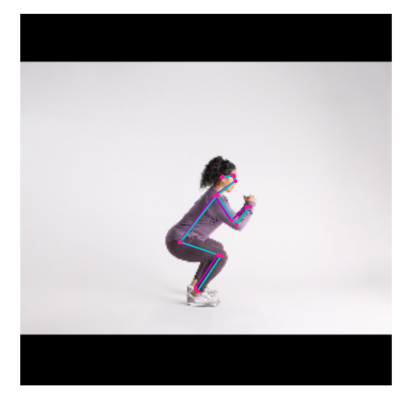

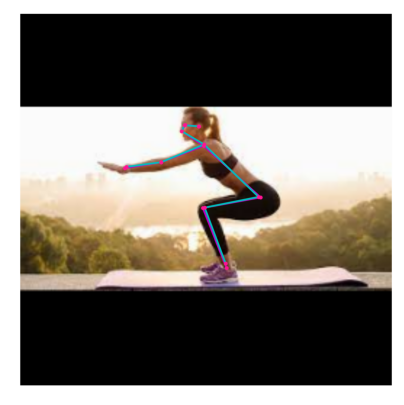

In [9]:
a = load_image(detector,imageProcessor,"../../Datasets/Trainer/raw/workout")
a